# Librerías

In [1]:
%matplotlib inline
import pandas as pd
from numpy import cos, sin, array,radians
import numpy as np
import matplotlib.pyplot as plt
import re
regex = re.compile('[^a-zA-Z]')
import string 
alphabet = string.ascii_letters
import scipy.interpolate 

# Funciones

In [2]:
def aportan_a_nodo(Nodo):    
    xjs = [Nodo[0]] + [Nodo[0]+1]
    yis = [Nodo[1]-1] + [Nodo[1]]
    try:
        del ady_horizontal, below_vertical, above_vertical
    except:pass

    try:
        ady_horizontal = horizontal[int(np.array(list(range(len(horizontal))))[NivelHorizontal=='Nivel %d'%Nodo[1]])]
    except:pass

    try:
        above_vertical = vertical[int(np.array(list(range(len(vertical))))[NivelVertical=='Nivel %d'%(Nodo[1])])]
    except:pass
    
    try:
        below_vertical = vertical[int(np.array(list(range(len(vertical))))[NivelVertical=='Nivel %d'%(Nodo[1]-1)])]
        
    except:pass

    aportan = []
    columns = []
    try:
        df_aportan = ady_horizontal[(ady_horizontal['Xj'].values==xjs[0])|(ady_horizontal['Xj'].values==xjs[1])]
        c = 0
        for i, row in df_aportan.iterrows():
            columns.append((['j', df_aportan['N'].values[c]] if Nodo[0]==row['Xj'] else ['i', df_aportan['N'].values[c]]) + [int(df_aportan['Nodo i'].values[c]), int(df_aportan['Nodo j'].values[c])])
            c+=1
        aportan.append(df_aportan)
    except:pass

    try:
        df_aportan = above_vertical[(above_vertical['Xi'].values==Nodo[0])]
        aportan.append(df_aportan)
        columns.append(['j', int(df_aportan['N'].values), int(df_aportan['Nodo i'].values), int(df_aportan['Nodo j'].values)])
        
    except:pass
    
    try:
        df_aportan = below_vertical[(below_vertical['Xi'].values==Nodo[0])]
        aportan.append(df_aportan)
        
        columns.append(['i', int(df_aportan['N'].values), int(df_aportan['Nodo i'].values), int(df_aportan['Nodo j'].values)])
    except:pass
    
    return columns

In [3]:
def enumerar(vector, df):
    global horizontal, vertical, NivelHorizontal, NivelVertical
    #print('Horizontal')
    C = 1
    horizontal = []
    for _, esto in sorted(pd.DataFrame(vector).groupby(1), reverse=True):  # to_concat
        if _!=0:
            esto.index.name = "Nivel %d"%_
            esto = esto.sort_values(0)
            esto[2] = [[np.nan]] + [[i, j] for i, j in zip(esto[0].values[:-1], esto[0].values[1:])]
            tmp = [np.nan]
            for i in range(len(esto)-1):
                tmp.append(C)
                C += 1
            esto[3] = tmp
            esto = esto.dropna()
            esto[3] = esto[3].astype(int)
            esto[4] = np.zeros(len(esto))*np.nan
            for _, i in esto.iterrows():
                esto.loc[_, 4] = df[(df[0]==i[0])&(df[1]==i[1])][2].values
            esto[4] = esto[4].astype(int)
            esto[5] = esto[4].values - 1
            esto.columns = ['Xj', 'Yj', 'InicioFin', 'N', 'Nodo j', 'Nodo i']
            #print(esto, '\n')
            horizontal.append(esto)

    NivelHorizontal = np.array([i.index.name for i in horizontal])
    #print('Vertical')

    to_concat = []
    for _, esto in pd.DataFrame(vector).groupby(0):  # Vertical
        esto = esto.sort_values(1)
        esto[4] = [np.nan] + [i for i, j in zip(esto[1].values[:-1], esto[1].values[1:])]
        esto[2] = [np.nan] + [[i, j] for i, j in zip(esto[1].values[:-1], esto[1].values[1:])]
        to_concat.append(esto.dropna())

    vertical = []
    for _, esto in sorted(pd.concat(to_concat).groupby(4), reverse=True):
        del esto[4]
        esto.index.name = "Nivel %d"%_
        esto = esto.sort_values(0)
        tmp = []
        for i in range(len(esto)):
            tmp.append(C)
            C += 1
        esto[3] = tmp
        esto[4] = np.zeros(len(esto))*np.nan
        esto[5] = np.zeros(len(esto))*np.nan
        for _, i in esto.iterrows():
            esto.loc[_, 4] = df[(df[0]==i[0])&(df[1]==i[1])][2].values
            esto.loc[_, 5] = df[(df[0]==i[0])&(df[1]==i[1]-1)][2].values
        esto[4] = esto[4].astype(int)
        esto[5] = esto[5].astype(int)
        esto.columns = ['Xi', 'Yi', 'InicioFin', 'N', 'Nodo i', 'Nodo j']
        #print(esto, '\n')
        vertical.append(esto)
    NivelVertical = np.array([i.index.name for i in vertical])

# Clase Edificio

In [4]:
class Edificio:
    def __init__(self, Lc, luces, hc, bc, hv, bv, Ec, Ev, alphac,alphav, pisos):
        self.Lc = Lc
        self.hc = hc
        self.bc = bc
        self.hv = hv
        self.bv = bv
        self.Ac = hc * bc
        self.Av = hv * bv
        self.Ic = bc * (hc**3) / 12
        self.Iv = bv * (hv**3) / 12
        self.Ec = Ec
        self.Ev = Ev
        self.pisos = pisos
        self.alphav = radians(alphav)
        self.alphac = radians(alphac)
        self.luces = dict(zip(('x', 'y'), luces))   
        self.xy_columnas = {}
        self.condensadas = {}
        
    def calc_lambda(self, alpha):
        """
        Calcula la matriz de rotación para el ángulo especificado
        """
        self.lamb = array([[ cos(alpha), sin(alpha), 0],
                           [-sin(alpha), cos(alpha), 0],
                           [     0     ,     0     , 1]])
        return self.lamb

    def calc_local(self, A, I, L, E):
        """
        Calcula la matriz de rigidez local para las propiedades geométricas y del material A,I,L,E
        """
        local = array([[ A*E/L,      0       ,      0       ,-A*E/L,      0       ,      0       ],
                       [   0  , 12*E*I/(L**3), 6*E*I/(L**2) ,   0  ,-12*E*I/(L**3),  6*E*I/(L**2)],
                       [   0  ,  6*E*I/(L**2),   4*E*I/L    ,   0  , -6*E*I/(L**2),   2*E*I/L    ],
                       [-A*E/L,      0       ,      0       , A*E/L,      0       ,      0       ],
                       [   0  ,-12*E*I/(L**3), -6*E*I/(L**2),   0  , 12*E*I/(L**3), -6*E*I/(L**2)],
                       [   0  ,  6*E*I/(L**2),   2*E*I/L    ,   0  , -6*E*I/(L**2),   4*E*I/L    ]])
        return local
    
    def calc_global(self, lamb, local):
        """
        Calcula la matriz global a partir de la rotación de la matriz local con la matriz lambda
        """
        Global = np.zeros((6, 6))  # Matriz de Rigidez en coordenadas globales
        Global[:3,:3] = lamb.dot(local[:3, :3]).dot(lamb.T)  # Porción Kii
        Global[:3,3:6] = lamb.dot(local[:3, 3:6]).dot(lamb.T)  # Porción Kij
        Global[3:6,3:6] = lamb.dot(local[3:6,3:6]).dot(lamb.T)  # Porción Kji
        Global[3:6,:3] = lamb.dot(local[3:6,:3]).dot(lamb.T)  # Porción Kjj
        return Global

    def local(self):
        """
        Obtiene las matrices locales para columnas y vigas
        """
        self.localv = self.calc_local(self.Av, self.Iv, self.Lv, self.Ev)
        self.localc = self.calc_local(self.Ac, self.Ic, self.Lc, self.Ec)
        return self.localc, self.localv
    
    def Global(self):
        """
        Obtiene las matrices globales para los elementos columnas y vigas
        """
        self.local()
        self.globalv = self.calc_global(self.calc_lambda(self.alphav),self.localv)
        self.globalc = self.calc_global(self.calc_lambda(self.alphac),self.localc)
        return self.globalc, self.globalv
    
    def ensamblar_texto(self, vector, columnas, direccion):
        """
        Código más robusto para calcular los aportes de elementos a nodos y mostrarlos en formato latex.
        """
        self.direccion = direccion
        self.xy_columnas[direccion.lower()] = columnas
        self.Lv = self.luces[direccion.lower()]
        self.columnas = columnas
        df = pd.DataFrame(vector).sort_values(0)
        df = df.sort_values(1, ascending=False)
        #print(df)
        #print('Columnas:', self.columnas, 'Dataframe: ', df.shape)
        df[0] = list(range(self.columnas)) * (self.pisos + 1)
        df[2] = list(range(1,len(df)+1))
        #print(df)
        enumerar(vector, df)
        formulas = []
        for i in df.values:
            expresion = ('$P_{%s}$ = '%i[2] + ' + '.join(['$f^{%s}_{%s}$'%(i[1], i[0]) for i in aportan_a_nodo(i[:2])]) 
                  + ' = ' + ' + '.join(['$k^{%s}_{%si}U_{%s} + k^{%s}_{%sj}U_{%s}$'%(i[1], i[0], i[2], i[1], i[0], i[3]) 
                                        for i in aportan_a_nodo(i[:2])])+'\n')
            #print(expresion)
            formulas.append(expresion)

        matriz = np.zeros((len(formulas), len(formulas))).tolist()
        c = 0
        for i in range(len(formulas)):
            for j in range(len(formulas)):
                matriz[i][j] = ' + '.join([r'$'+k.strip(r"'U_{%s}$'"%(j+1))+r'}$' for k in formulas[c].split() if 'U_{%s}'%(j+1) in k])
            c += 1
        self.ensamblada_texto = pd.DataFrame(matriz)
        return self.ensamblada_texto
    
    def ensamblar(self):
        """
        A partir de la matriz ensamblada calculada arriba, obtiene numéricamente los valores
        """
        m = self.ensamblada_texto
        ensamblada = np.zeros(np.array(m.shape)*3)
        aux_dic = {'ii':[slice(0, 3), slice(0, 3)], 'ij':[slice(0, 3), slice(3, 6)], 'ji':[slice(3, 6), slice(0, 3)], 'jj':[slice(3, 6), slice(3, 6)]}
        for idx in range(m.shape[0]):
            for idy in range(m.shape[1]):
                ijs = regex.sub('', m[idy][idx]).split('k')[1:]
                c = 0
                for i in m[idy][idx].split("^"):
                    if '_' in i:
                        for j in i.replace('{', '').replace('}', '').split('_'):
                                try: # Entra entero - elemento
                                    donde = [(int(j) in column['N'].values) for column in [pd.concat(horizontal, axis=0), pd.concat(vertical, axis=0)]]
                                    if sum(donde)>=1:
                                        ensamblada[3*idx:3*(idx+1),3*idy:3*(idy+1)] += self.globalv[aux_dic[ijs[c]][0],aux_dic[ijs[c]][1]] if donde[0] else self.globalc[aux_dic[ijs[c]][0],aux_dic[ijs[c]][1]]
                                    c += 1

                                except:pass 
        self.ensamblada = ensamblada
        return self.ensamblada
    
    def condensar(self, gdl=1):
        """
        Calculadas las matrices ensambladas se procede a condensar. Las suposiciones son básicas: los nodos de 
        cimentacion no tienen desplazamientos y el eje perperdicular al de estudio tampoco se desplaza.
        """
        tmp = np.delete(self.ensamblada, list(range(gdl, self.ensamblada.shape[1], 3)), axis=1) # ys columnas
        tmp = np.delete(tmp, list(range(1, tmp.shape[0], 3)), axis=0) # ys filas
        tmp = np.delete(tmp, list(range(tmp.shape[0]-2*self.columnas, tmp.shape[0])), axis=0)  # 2 GDL * 6 columnas (columnas)
        tmp = np.delete(tmp, list(range(tmp.shape[1]-2*self.columnas, tmp.shape[1])), axis=1)  # 2 GDL * 6 columnas (filas)

        lista = []
        for j in range(0, tmp.shape[1], 2*self.columnas):
            for i in range(j, j+self.columnas*2, 2):
                if i!=j:
                    tmp[:,j] += tmp[:,i]
                    lista.append(i)
        tmp = np.delete(tmp,lista,  axis=1)
        
        lista = []
        for j in range(0, tmp.shape[0], 2*self.columnas):
            for i in range(j, j+self.columnas*2, 2):
                if i!=j:
                    tmp[j] += tmp[i]
                    lista.append(i)
        tmp = np.delete(tmp, lista,  axis=0)
        
        primeros5 = list(range(0, tmp.shape[0], self.columnas+1))
        restantes = np.delete(list(range(tmp.shape[1])), primeros5)
        tmp = tmp[np.r_[primeros5, restantes],:]
        tmp = tmp[:, np.r_[primeros5, restantes]]

        self.K0 = tmp[:self.pisos, :self.pisos]
        self.K1 = tmp[:self.pisos, self.pisos:]
        self.K2 = tmp[self.pisos:, :self.pisos]
        self.K3 = tmp[self.pisos:, self.pisos:]

        self.condensada = (self.K0 - self.K1.dot(np.linalg.inv(self.K3)).dot(self.K2))
        self.condensadas[self.direccion] = self.condensada
        return self.condensada
    
    def calc_masa(self, m, A):
        """
        Calcula la matriz de masa
        """
        self.last_local_masa = np.array([[       m*A          ,       0            ,                   -self.centroide['y']                                     ],
                                         [         0          ,       m*A          ,                    self.centroide['x']                                     ],
                                         [-self.centroide['y'], self.centroide['x'], (m*A)*self.Jo/A+(m*A)*(self.centroide['x']**2+self.centroide['y']**2)**0.5]])
        return self.last_local_masa
    
    def Masa(self, m_piso, m_cubierta, centroide):
        """
        Obtiene la matriz de masa
        """
        self.X = self.luces['x'] * 5
        self.Y = self.luces['y'] * 2
        self.Ixx = 1/12 * self.X * self.Y**3
        self.Iyy = 1/12 * self.Y * self.X**3
        self.Jo = self.Ixx + self.Iyy
        self.area_cubierta = self.X * self.Y
        self.area_piso = self.X * self.Y
        self.m_piso = m_piso # kg/m2
        self.m_cubierta = m_cubierta  # kg/m2
        self.centroide = centroide

        self.masa = np.zeros((self.pisos*3, self.pisos*3))
        for idx in range(self.pisos):
            if idx!=0:
                self.masa[3*idx:3*(idx+1),3*idx:3*(idx+1)] = self.calc_masa(self.m_piso, self.area_piso)
            else:
                self.masa[3*idx:3*(idx+1),3*idx:3*(idx+1)] = self.calc_masa(self.m_cubierta, self.area_cubierta)
        self.masa = self.masa / 1000
        return self.masa
    
    def transformacion(self):
        """Este es muy dificil de automatizar, porque se tiene que decir los tipos de porticos existentes"""
        self.centroide2 = dict(zip(('x', 'y'),(self.luces['x'] * (self.xy_columnas['x']-1)/2, self.luces['y'] * (self.xy_columnas['y']-1)/2)))
        df = pd.DataFrame(index=[alphabet[i].upper() for i in range(self.xy_columnas['x'])]+[i for i in range(1, self.xy_columnas['y']+1)],
                     columns=['TIPO', 'Xa', 'Ya', 'Xb', 'Yb', 'd', 'a', 'cos(a)', 'sen(a)']+['r%s'%i for i in range(1, self.pisos+1)])
        df.index.name='EJE'
        df.Xa = [i*self.luces['x'] for i in range(self.xy_columnas['x'])] + [0]*self.xy_columnas['y']
        df.Ya = [0]*self.luces['x'] + [i*self.luces['y'] for i in sorted(range(self.xy_columnas['y']), reverse=True)]
        df.Xb = [i*self.luces['x'] for i in range(self.xy_columnas['x'])] + [self.luces['x']*(self.xy_columnas['x']-1)]*self.xy_columnas['y']
        df.Yb = [self.luces['y']*(self.xy_columnas['y']-1)]*self.luces['x'] + [i*self.luces['y'] for i in sorted(range(self.xy_columnas['y']), reverse=True)]
        df.d = df.eval('((Xb-Xa)**2+(Yb-Ya)**2)**0.5')
        df.a = self.xy_columnas['x']*[self.alphac] + self.xy_columnas['y']*[self.alphav]
        df['cos(a)'] = df.eval('cos(a)')
        df['sen(a)'] = df.eval('sin(a)')
        for i in range(1, self.pisos+1):
            exec("df['r%s'%i] = (self.centroide2['x']-df.Xa)*df['sen(a)'] + (self.centroide2['y'])*df['cos(a)']-df.Ya")
        matrices_transformacion = {}
        self.rigidez = np.zeros((self.pisos*3, self.pisos*3))
        for idx in df.index:
            matrices_transformacion[idx] = pd.DataFrame(0,columns=list(sorted(range(1, self.pisos+1), reverse=True)),index=np.array([['F%sz'%i, 'F%sy'%i, 'F%sx'%i] for i in range(1, self.pisos+1)]).reshape(-1)[::-1])
            for piso in sorted(range(1, self.pisos+1),reverse=True):
                matrices_transformacion[idx].loc[['F%sx'%piso, 'F%sy'%piso, 'F%sz'%piso], piso] = df.loc[idx, ['cos(a)', 'sen(a)', 'r%s'%(piso)]].values
            condensada = self.condensadas['x'] if str(idx).isnumeric() else self.condensadas['y']
            matrices_transformacion[idx] = matrices_transformacion[idx].values.dot(condensada).dot(matrices_transformacion[idx].T.values)
            self.rigidez = self.rigidez +  matrices_transformacion[idx]
        self.df_transformacion = df
        return self.rigidez
        

# Ensamblada 58x58

Suma ensamblada:  11181361.607142858 
Shape ensamblada:  (54, 54)
Suma condensada:  111342.30536731819 
Shapecondensada:  (5, 5)


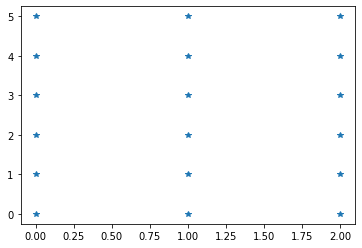

In [5]:
E = Edificio(3.2, (6, 7), 0.5, 0.5, 0.6, 0.5, 2.5e7, 2.5e7, 90, 0, 5)
vector = np.array([[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[2, 0],[2, 1],[2, 2],
                   [2, 3],[2, 4],[2, 5]])
# vector = np.array([[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[2, 0],[2, 1],[2, 2],
#                    [2, 3],[2, 4],[2, 5],[3, 0],[3, 1],[3, 2],[3, 3],[3, 4],[3, 5],[4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5],
#                    [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]])
plt.plot(vector[:,0], vector[:,1], '*')
m = E.ensamblar_texto(vector, 3, 'y')
E.Global();
E.ensamblar()
print('Suma ensamblada: ',E.ensamblada.sum(), '\nShape ensamblada: ',  E.ensamblada.shape)
E.condensar()
print('Suma condensada: ',E.condensada.sum(), '\nShapecondensada: ', E.condensada.shape)

In [6]:
E.K3.shape

(15, 15)

# Ensamblada 108x108

Suma ensamblada:  25898437.499999993 
Shape ensamblada:  (108, 108)
Suma condensada:  233719.93753420585 
Shapecondensada:  (5, 5)


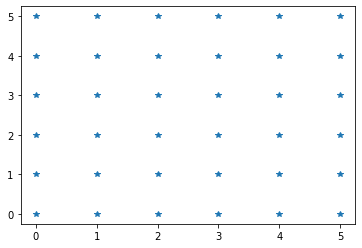

In [7]:
vector = np.array([[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[2, 0],[2, 1],[2, 2],
                   [2, 3],[2, 4],[2, 5],[3, 0],[3, 1],[3, 2],[3, 3],[3, 4],[3, 5],[4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5],
                   [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]])
plt.plot(vector[:,0], vector[:,1], '*')
m = E.ensamblar_texto(vector, 6, 'x')
E.Global();
E.ensamblar()
print('Suma ensamblada: ',E.ensamblada.sum(), '\nShape ensamblada: ',  E.ensamblada.shape)
E.condensar()
print('Suma condensada: ',E.condensada.sum(), '\nShapecondensada: ', E.condensada.shape)

In [8]:
E.K3.shape

(30, 30)

# Matriz de Masa

In [9]:
E.Masa(1500, 600, dict(zip(('x', 'y'),(0, 0))))
E.masa.sum()
print('Suma masa: ',E.masa.sum(), '\nShape masa: ', E.masa.shape)

Suma masa:  258720.0 
Shape masa:  (15, 15)


# Matriz de Transformación

In [10]:
E.transformacion()
print('Suma rigidez: ',E.rigidez.sum(), '\nShape rigidez: ', E.rigidez.shape)

Suma rigidez:  94419419.90456918 
Shape rigidez:  (15, 15)


In [9]:
self = E  # Esto se hace porque sigue en desarrollo la clase

# Valores y vectores propios

In [13]:
eigvalues, phi  = np.linalg.eig(np.linalg.inv(self.masa).dot(self.rigidez.astype(float)))
phi.sum()

-0.2857495963475858

In [14]:
phi = phi[:, pd.DataFrame(eigvalues, columns=['values']).sort_values('values').index]
#eigvalues = eigvalues[pd.DataFrame(eigvalues, columns=['values']).sort_values('values').index]
omega = eigvalues ** 0.5

A continuación se reordena

In [15]:
los_x = (pd.DataFrame(phi).round(5).loc[0] != 0)
los_y = (pd.DataFrame(phi).round(5).loc[1] != 0)
los_z = (pd.DataFrame(phi).round(5).loc[2] != 0)
phit = []
for i in range(len(pd.DataFrame(phi).loc[:, los_x].columns)):
    phit.append(pd.DataFrame(phi).loc[:, los_x].iloc[:,i])
    phit.append(pd.DataFrame(phi).loc[:, los_y].iloc[:,i])
    phit.append(pd.DataFrame(phi).loc[:, los_z].iloc[:,i])

### Normalizamos los vectores propios con respecto a la masa

$$\phi_N = \frac{1}{\sqrt{\phi^T * M * \phi}}*\phi$$

In [16]:
for i in range(len(phi)):
    phi[:, i] = 1/(phi[:, i].T.dot(self.masa).dot(phi[:, i]))**0.5 * phi[:, i]

Nunca entendí por qué los valores propios salen del método de numpy con otro signo diferente al de matlab. Por lo que los resultados se ven alterados en lo que continúa de acá para abajo. A continuación engaño el código con el Phi calculado por compañeros del curso hecho en matlab, para efectos de comparación con lo que ellos hicieron en excel.

In [17]:
phi = np.array("""0.026661340311672100000000	-0.000000000000000146987955	-0.000000000000000045265788	0.028482812421679500000000	0.000000000000000094516113	-0.000000000000000000533672	0.030851749117955500000000	-0.000000000000000061210272	0.000000000000000000223090	-0.031100884845367700000000	0.000000000000000096772275	0.000000000000000001879465	0.022957805552545700000000	0.000000000000000121553982	0.000000000000000000648566
0.000000000000000456163343	0.026991152027972600000000	-0.000000000000000059531112	-0.000000000000000024638262	0.029348137274303500000000	0.000000000000000009859227	-0.000000000000000013104045	-0.032006881525321700000000	0.000000000000000012648177	-0.000000000000000055410203	-0.030869060902445300000000	0.000000000000000002627806	0.000000000000000049138675	-0.020026960154018200000000	-0.000000000000000001701849
-0.000000000000000138985037	-0.000000000000000274090081	0.002815035171326280000000	0.000000000000000013957355	-0.000000000000000026014011	-0.003047674364095830000000	-0.000000000000000011216808	0.000000000000000045857019	0.003321883068291020000000	0.000000000000000001786889	0.000000000000000017955719	-0.003243240989920490000000	-0.000000000000000014190376	0.000000000000000031585526	-0.002163740942279390000000
0.025047945885491200000000	-0.000000000000000140577844	-0.000000000000000040710835	0.014858148919743200000000	0.000000000000000053524675	-0.000000000000000000317428	-0.002112297910361600000000	-0.000000000000000000694621	-0.000000000000000000519722	0.018073978917715900000000	-0.000000000000000064468321	-0.000000000000000002884318	-0.020199180392225600000000	-0.000000000000000093092973	-0.000000000000000001514689
0.000000000000000443132821	0.025191364371121400000000	-0.000000000000000060770118	-0.000000000000000017232105	0.014293551817784600000000	0.000000000000000007514039	-0.000000000000000010808163	0.003773866291436490000000	-0.000000000000000004784317	0.000000000000000027381190	0.019494603222351800000000	-0.000000000000000003356272	-0.000000000000000045977770	0.018817797513862300000000	0.000000000000000001387157
-0.000000000000000127570325	-0.000000000000000249152968	0.002632030836569470000000	-0.000000000000000001587810	-0.000000000000000016056105	-0.001511417730647060000000	0.000000000000000001843617	-0.000000000000000001344550	-0.000351739843847404000000	-0.000000000000000001790939	0.000000000000000002317349	0.002008955829503710000000	0.000000000000000011210836	-0.000000000000000020184713	0.002001904127497810000000
0.020839247080388900000000	-0.000000000000000130672881	-0.000000000000000032407074	-0.009968859982502230000000	-0.000000000000000026796115	0.000000000000000001715843	-0.024281524075995800000000	0.000000000000000053377963	-0.000000000000000003071661	0.000544426995825087000000	-0.000000000000000033137240	0.000000000000000001489542	0.021535096630069000000000	0.000000000000000061558492	-0.000000000000000001025764
0.000000000000000378265659	0.020788972713397800000000	-0.000000000000000055811802	-0.000000000000000006589415	-0.010834755476850200000000	-0.000000000000000000651419	0.000000000000000017724237	0.023597287435655100000000	-0.000000000000000003208680	-0.000000000000000000381619	-0.002452770143540210000000	0.000000000000000002856345	0.000000000000000053063279	-0.021791746577135200000000	-0.000000000000000000923879
-0.000000000000000109345157	-0.000000000000000212623505	0.002176893860311460000000	0.000000000000000001193924	-0.000000000000000003649743	0.001110343614544490000000	-0.000000000000000000523087	-0.000000000000000038762976	-0.002488555100073200000000	-0.000000000000000004897073	-0.000000000000000039176525	-0.000184303669501888000000	-0.000000000000000002166009	0.000000000000000007040197	-0.002276095408675300000000
0.014241871238608900000000	-0.000000000000000100469889	-0.000000000000000021208378	-0.025295827894040500000000	-0.000000000000000063276837	0.000000000000000002815010	0.005649106650851700000000	-0.000000000000000014103624	-0.000000000000000000102389	-0.019112249510320600000000	0.000000000000000037696088	-0.000000000000000002177688	-0.018638704214137700000000	-0.000000000000000081792719	0.000000000000000000477287
0.000000000000000254919754	0.013970019898270000000000	-0.000000000000000041861491	0.000000000000000017324694	-0.025413801357702400000000	-0.000000000000000008907005	-0.000000000000000003272423	-0.007387294904716890000000	0.000000000000000005721030	-0.000000000000000028215608	-0.017196950472276200000000	0.000000000000000004814338	-0.000000000000000048079286	0.019899035161022000000000	0.000000000000000001472335
-0.000000000000000064840665	-0.000000000000000138513649	0.001469410789375700000000	-0.000000000000000012417506	0.000000000000000014886615	0.002656970463515800000000	-0.000000000000000006654967	-0.000000000000000004999775	0.000728323932996010000000	-0.000000000000000000162460	-0.000000000000000019565158	-0.001846165277316560000000	-0.000000000000000008998307	-0.000000000000000008322584	0.002054695200031680000000
0.006202100618223040000000	-0.000000000000000047526838	-0.000000000000000009800255	-0.017400335583121400000000	-0.000000000000000038469390	0.000000000000000002412181	0.024095700819413900000000	-0.000000000000000060346632	-0.000000000000000000856302	0.022542235382035400000000	-0.000000000000000050246161	-0.000000000000000001119741	0.012542275822991300000000	0.000000000000000098393499	0.000000000000000000604133
0.000000000000000110118110	0.005826232991193470000000	-0.000000000000000017188578	0.000000000000000006558684	-0.016589679727271900000000	-0.000000000000000008038743	-0.000000000000000009805051	-0.023492110041360100000000	0.000000000000000000155327	0.000000000000000035092203	0.022898717806509300000000	-0.000000000000000003916306	0.000000000000000034209446	-0.014209455007245700000000	-0.000000000000000001298053
-0.000000000000000028313882	-0.000000000000000063569816	0.000619535294827346000000	-0.000000000000000002009833	0.000000000000000004127583	0.001757028259536610000000	0.000000000000000014211179	0.000000000000000037705081	0.002473493168885270000000	0.000000000000000002037974	0.000000000000000051623158	0.002386120703855550000000	0.000000000000000012461011	0.000000000000000019094220	-0.001447930144471480000000
""".split()).astype(float).reshape(phi.shape)

# Modos de Vibracion

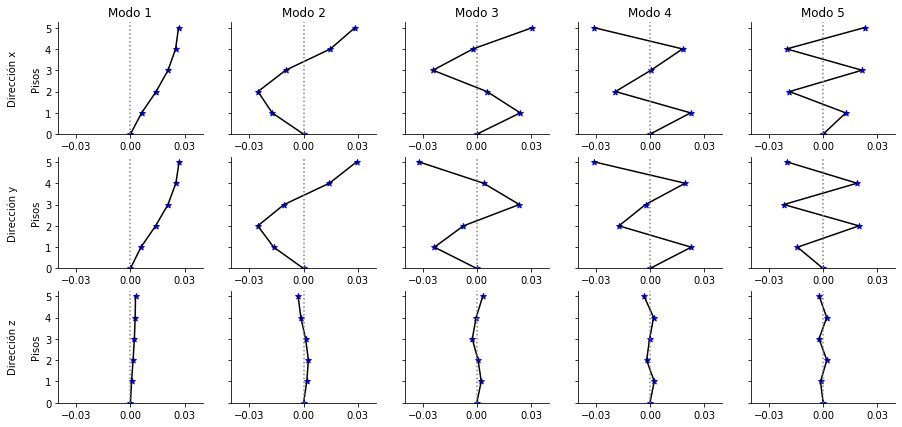

In [18]:
dir_dic = {'x':0, 'y':1, 'z':2}
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import make_interp_spline, BSpline
def plot_modos():
    
    f, ax = plt.subplots(3, 5, figsize=(15, 7), sharey=True)#, sharex=True)
    for direccion in ['x', 'y', 'z']:
        algin = pd.DataFrame(phi).loc[:, list(range(dir_dic[direccion], 15, 3))]
        algin[algin.round(5)==0] = np.nan
        if direccion=='y':
            c = 1
        elif direccion=='z':
            c = 2
        elif direccion=='x':
            c = 0
        ax[c][0].set_ylabel('Dirección %s\n\nPisos'%direccion)
        for idx, mode in enumerate(algin.dropna().columns):
            if direccion=='x':
                ax[c][idx].set_title('Modo %s'%(idx+1))
            x = np.r_[[0], algin.dropna()[mode].values[::-1]]
            y = range(len(algin.dropna())+1)
            y_smooth = np.linspace(0, self.pisos, 12)
            x_smooth = scipy.interpolate.interp1d(y, x, kind='cubic')
            ysmoothed = gaussian_filter1d(y, sigma=10)
#             ax[c][idx].plot(x, ysmoothed)
#             ax[c][idx].plot(x_smooth(y_smooth), y_smooth, c='k')  
            ax[c][idx].plot(x, y, c='k')
            ax[c][idx].axvline(0, color='gray', ls=':')
            ax[c][idx].set_xlim([-0.04, 0.04])
            ax[c][idx].set_ylim(bottom=0)
            ax[c][idx].set_xticks([-0.03,0,0.03])
            ax[c][idx].set_yticks(np.arange(0,6, 1))
            ax[c][idx].scatter(x, y, marker='*', c='b')
            ax[c][idx].spines['top'].set_visible(False)
            ax[c][idx].spines['right'].set_visible(False)
#         f.set_ylabel(direccion)
    return
plot_modos()
# plot_modos('y')
# plot_modos('z')
plt.savefig('Modos.pdf', dpi=300, bbox_inches='tight')

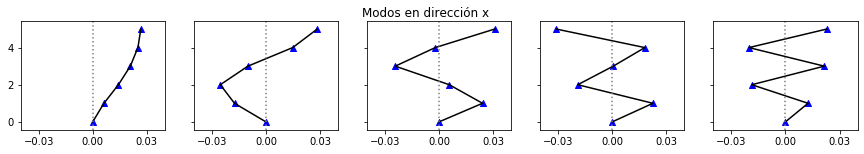

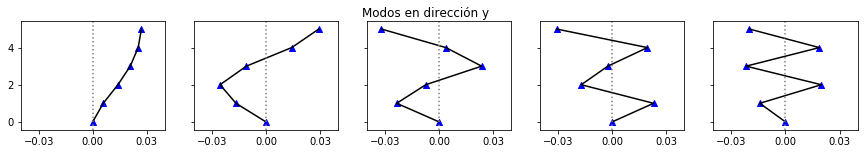

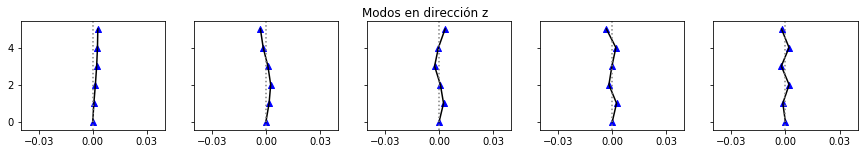

In [19]:
dir_dic = {'x':0, 'y':1, 'z':2}
def plot_modos(direccion):
    algin = pd.DataFrame(phi).loc[:, list(range(dir_dic[direccion], 15, 3))]
    algin[algin.round(5)==0] = np.nan
    f, ax = plt.subplots(1, 5, figsize=(15, 2), sharey=True)
    for idx, mode in enumerate(algin.dropna().columns):
        x = np.r_[[0], algin.dropna()[mode].values[::-1]]
        y = range(len(algin.dropna())+1)
        y_smooth = np.linspace(0, self.pisos, 60)
        x_smooth = scipy.interpolate.interp1d(y, x, kind='cubic')
        #ax[idx].plot(x_smooth(y_smooth), y_smooth, c='k')  
        ax[idx].plot(x, y, c='k')
        ax[idx].axvline(0, color='gray', ls=':')
        ax[idx].set_xlim([-0.04, 0.04])
        ax[idx].set_xticks([-0.03,0,  0.03])
        ax[idx].scatter(x, y, marker='^', c='b')
    f.suptitle('Modos en dirección %s'%direccion)
    return

plot_modos('x')
plot_modos('y')
plot_modos('z')
plt.savefig('Modos.pdf', dpi=300, bbox_inches='tight')

# Comprobaciones

In [20]:
self.comprobacion1 = pd.DataFrame(phi.T .dot(self.masa).dot(phi).round(5))
self.comprobacion2 = pd.DataFrame(phi.T .dot(self.rigidez.astype(float)).dot(phi))

In [207]:
E.comprobacion2.round()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,69.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
1,0.0,57.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
2,-0.0,-0.0,90.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
3,-0.0,0.0,-0.0,655.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
4,-0.0,0.0,-0.0,0.0,556.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
5,0.0,-0.0,-0.0,-0.0,0.0,874.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
6,-0.0,-0.0,-0.0,0.0,0.0,0.0,1908.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
7,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1700.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0
8,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,2638.0,0.0,0.0,-0.0,0.0,0.0,-0.0
9,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,3601.0,-0.0,-0.0,0.0,0.0,0.0


# Participación Modal

In [21]:
identidad = np.eye(3)
self.Y = np.zeros((len(identidad) * self.pisos, 3))
for i in range(self.pisos):
    self.Y[i*3:3*(i+1)] = identidad
self.Y

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [22]:
phi.shape, self.masa.shape, self.Y.shape

((15, 15), (15, 15), (15, 3))

In [23]:
alpha = phi.T.dot(self.masa.dot(self.Y))  #
alpha.round(3)

array([[ 48.507,   0.   ,  -0.   ],
       [ -0.   ,  48.241,  -0.   ],
       [ -0.   ,  -0.   , 461.694],
       [-16.641,  -0.   ,  -0.   ],
       [ -0.   , -16.887,  -0.   ],
       [  0.   ,  -0.   , 160.758],
       [  9.886,  -0.   ,   0.   ],
       [ -0.   , -10.276,   0.   ],
       [ -0.   ,   0.   ,  97.258],
       [  6.053,   0.   ,  -0.   ],
       [ -0.   ,   6.549,   0.   ],
       [ -0.   ,   0.   ,  61.413],
       [  2.786,   0.   ,   0.   ],
       [  0.   ,  -3.336,   0.   ],
       [ -0.   ,  -0.   , -30.664]])

In [24]:
Mtotal = self.Y.T.dot(self.masa.dot(self.Y))  #
Mtotal.round(3)

array([[  2772.,      0.,      0.],
       [     0.,   2772.,      0.],
       [     0.,      0., 253176.]])

In [25]:
Mtotal2 = alpha.T.dot(np.eye(15).dot(alpha))
Mtotal2.round(3)

array([[  2772.,      0.,     -0.],
       [     0.,   2772.,     -0.],
       [    -0.,     -0., 253176.]])

In [26]:
alpha[alpha.round(5)==0.] = np.nan
alpha[:, 1] = np.r_[alpha[1:, 1], [np.nan]]
alpha[:, 2] = np.r_[alpha[2:, 2], [np.nan]*2]
alpha = pd.DataFrame(alpha).dropna()
alpha.columns = ['x', 'y', 'z']
alpha.index = list(range(5))

In [27]:
alpha**2 / np.nansum(alpha**2,axis=0)

,x,y,z
0,0.848830,0.839537,0.841950
1,0.099896,0.102881,0.102076
2,0.035256,0.038093,0.037362
3,0.013218,0.015475,0.014897
4,0.002801,0.004015,0.003714


In [28]:
porcentajes_masa = alpha**2 / np.nansum(alpha**2,axis=0)
print('Porcentaje de Masa \n',(porcentajes_masa), '\n\nAcumulado'), print(np.cumsum(porcentajes_masa, axis=0))

Porcentaje de Masa 
           x         y         z
0  0.848830  0.839537  0.841950
1  0.099896  0.102881  0.102076
2  0.035256  0.038093  0.037362
3  0.013218  0.015475  0.014897
4  0.002801  0.004015  0.003714 

Acumulado
          x         y         z
0  0.848830  0.839537  0.841950
1  0.948726  0.942417  0.944027
2  0.983982  0.980511  0.981389
3  0.997199  0.995985  0.996286
4  1.000000  1.000000  1.000000


(None, None)

# Periodos

In [29]:
ws = pd.DataFrame()
for i in range(0, 3):
    ws = pd.concat((ws, pd.DataFrame(np.diag(self.comprobacion2)[list(range(i, 15, 3))])), axis=1)
ws.columns = ['x', 'y', 'z']

In [30]:
ws_raiz = ws**0.5

In [31]:
matriz_T = 2 * np.pi /(ws_raiz)

In [32]:
matriz_T

,x,y,z
0,0.755794,0.834655,0.662649
1,0.245435,0.266393,0.212488
2,0.143849,0.152405,0.122342
3,0.104701,0.108427,0.087560
4,0.089034,0.090194,0.073249


# Sismo

In [33]:
#START cm1.th, 7.1 Mw, 23.6 km, ndata = 2200, dt = 0.020, PGA = 0.1161g, unit = g 
g = 9.81
sismo  = pd.read_excel('sismo_tarea2.xlsx', skiprows=[0], header=None,index_col=1, sheet_name='cm1 N-S')

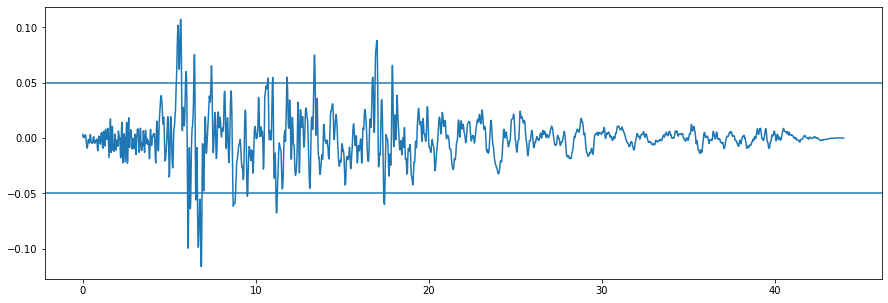

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(sismo[2])
plt.axhline(0.05)
plt.axhline(-0.05)

In [35]:
NS = pd.concat((sismo[2][sismo[2]>0.05], sismo[2][sismo[2]<-0.05]), axis=0)
sismo.loc[NS.index[0]:NS.index[-1]]

,0,2
1,,
5.42,272,0.054419
5.44,273,0.068482
5.46,274,0.081587
5.48,275,0.093524
5.50,276,0.101924
...,...,...
17.36,869,-0.017862
17.38,870,-0.039717
17.40,871,-0.054862


In [36]:
#START cm1.th, 7.1 Mw, 23.6 km, ndata = 2200, dt = 0.020, PGA = 0.1161g, unit = g 
g = 9.81
sismo2  = pd.read_excel('sismo_tarea2.xlsx', skiprows=[0], header=None,index_col=1, sheet_name='cm2 E-O')

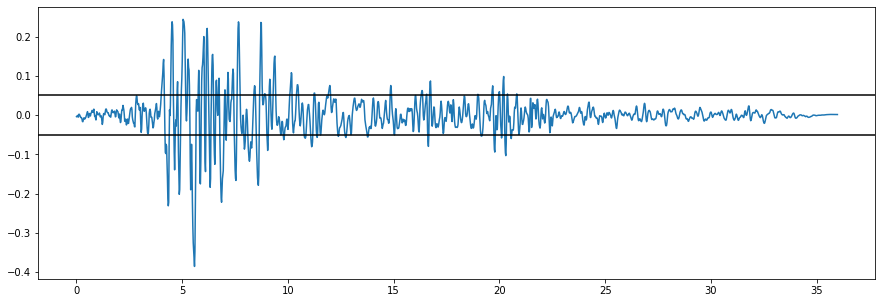

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(sismo2[2])
plt.axhline(0.05, color='k')
plt.axhline(-0.05, color='k')

In [38]:
EO = pd.concat((sismo2[2][sismo2[2]>=0.05], sismo2[2][sismo2[2]<=-0.05]), axis=0)
sismo2.loc[EO.index[0]:EO.index[-1]]

,0,2
1,,
4.02,202,0.062061
4.04,203,0.075984
4.06,204,0.086722
4.08,205,0.107168
4.10,206,0.131297
...,...,...
20.48,1025,-0.002626
20.50,1026,-0.008522
20.52,1027,-0.036955


Text(0.5, 0, '')

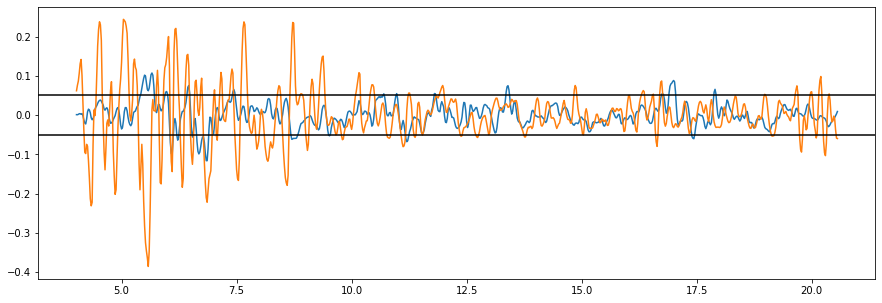

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(pd.concat((sismo[2], sismo2[2]), axis=1).loc[EO.index[0]:EO.index[-1]])
plt.axhline(0.05, color='k')
plt.axhline(-0.05, color='k')
plt.xlabel('')

In [40]:
split = pd.concat((sismo[2], sismo2[2]), axis=1).loc[EO.index[0]:EO.index[-1]]
split.columns = ['NS', 'EO']
split.to_excel('sismos_recortados.xlsx')

In [41]:
split = pd.concat((sismo[[2]], sismo2[[2]]), axis=1)
split.columns = ['NS', 'EO']

### Gráfico: acelerograma

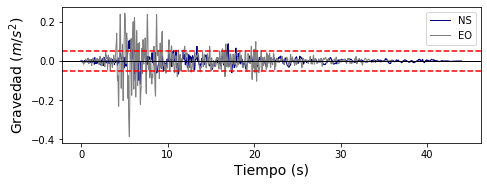

In [42]:
plt.figure(figsize=(7.5, 2.5))
plt.plot(split['NS'], color='navy', lw=1, label='NS')
plt.plot(split['EO'], color='gray', lw=1, label='EO')
plt.axhline(0.05, color='r', ls='--')
plt.axhline(-0.05, color='r', ls='--')
plt.axhline(0, color='k', lw=1)
plt.xlabel('')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
plt.xlabel('Tiempo (s)', fontsize=14)
plt.ylabel('Gravedad ($m/s^2$)', fontsize=14)
#plt.grid(axis='y')
plt.legend()
plt.savefig('acelerogramas.pdf', dpi=300, bbox_inches='tight')

In [43]:
print('Este-Oeste\n', np.abs(EO).max(), '\n\nNorte-Sur\n', np.abs(NS).max())

Este-Oeste
 0.3854195 

Norte-Sur
 0.1161095


# Beta-Newmark

In [44]:
amortiguamientos = [0.02, 0.05, 0.1, 0.2, 0.3]

In [45]:
I = 1.  # COEFICIENTE DE IMPORTANCIA (I)
Y = 0.5  # INTEGRACIÓN GAMMA (Y)
amortiguacion = amortiguamientos[1]  # FACTOR DE AMORTIGUACION
masa_integracion = 1  # MASA DE INTEGRACIÓN [kN s2/m]
g = 9.81  # GRAVEDAD [m/s2]
dt = 0.02 # DELTA DE TIEMPO [S]


d0 = 0  # Desplazamiento inicial [m]
v0 = 0  # Velocidad inicial [m/s]

T = 0.07
w = 2 * np.pi / T  # ω 
k = w**2 * masa_integracion  # k [kN/m]
c = 2 * amortiguacion * masa_integracion * w  # c [kN s/m]
a = 1  # Factor de participacion
b = 0  # b

estable = dt <= 2/w  # ¿ESTABLE?
estable

True

In [46]:
periodos = np.arange(0.07, 4.01, 0.01)

def beta_newmark(T, dire, amortiguacion=amortiguamientos[1], split=split):
    """
    Args: 
        split: refiere al dataframe del espectro recortado.
    """
    tabla = []
    i = 0
    w = 2 * np.pi / T  # ω 
    k = w**2 * masa_integracion  # k [kN/m]
    c = 2 * amortiguacion * masa_integracion * w  # c [kN s/m]
    
    row = [split[dire].index[i], split[dire].values[i]]
    row.append(split[dire].values[i] * -g)
    row.append(d0)
    row.append(k * row[-1])
    row.append(row[-3])
    row.append(v0)
    row.append((row[-2]+row[-5])/g)
    tabla.append(row)

    for i in range(1, len(split)):
        row2 = [split[dire].index[i], split[dire].values[i]]
        row2.append(split[dire].values[i] * -g)
        ########################################################################################
        U = row[-5] + dt * row[-2] + dt**2 * ((0.5-b) * row[-3] + b * row[-1])
        row2.append(U)
        ########################################################################################
        histeresis = U * k
        row2.append(histeresis)
        ########################################################################################
        A = ((masa_integracion + dt *  Y * c )**(-1)) * (-row2[2] * masa_integracion - row2[-1] 
                                                         - c * (row[-2] + dt*(1-Y)*row[-3]))
        row2.append(A)
        ########################################################################################
        V = row[-2] + dt * ((1 - Y) * row[-3] + Y * row2[-1])
        row2.append(V)
        ########################################################################################
        A_total = (row2[-2]+row2[-5])/g
        row2.append(A_total)
        ########################################################################################
        row = row2
        tabla.append(row)

    tabla = pd.DataFrame(tabla, columns=['t', 'A_sismo_g', 'A_sismo', 'Desplazamiento', 'Histeresis',
                                 'A_relativa', 'V_relativa', 'A_total_g'])
    final_row = np.nanmax(np.abs(tabla[['Desplazamiento', 'V_relativa', 'A_total_g']]), axis=0)
    return final_row



In [47]:
beta_newmark(0.07, 'EO', split=split.iloc[1:,:])

array([0.00055773, 0.01926659, 0.45181395])

In [48]:
periodos = np.arange(0.07, 4.01, 0.01)

In [49]:
dire='EO'
espectroEO = pd.DataFrame(columns=['Desplazamiento', 'V_relativa', 'A_total_g'])
espectroEO.loc[0] = np.array([0, 0, np.abs(split[dire].values[0] * -g)])
for t in periodos:
    espectroEO.loc[t] = beta_newmark(t, dire)
espectroEO['Sa'] = (2 * np.pi / espectroEO.index)**2 * espectroEO['Desplazamiento'] / g

In [50]:
espectroEO.loc[0, 'Sa'] = 0

In [57]:
def beta_newmark_tabla(T, dire, a, amortiguacion=0.05):
    tabla = []
    i = 0
    w = 2 * np.pi / T  # ω 
    k = w**2 * masa_integracion  # k [kN/m]
    c = 2 * amortiguacion * masa_integracion * w  # c [kN s/m]
    
    row = [split[dire].index[i], split[dire].values[i]]
    row.append(split[dire].values[i] * -g * a * I)
    row.append(d0)
    row.append(k * row[-1])
    row.append(row[-3])
    row.append(v0)
    row.append((row[-2]+row[-5])/g)
    tabla.append(row)

    for i in range(1, len(split)):
        row2 = [split[dire].index[i], split[dire].values[i]]
        row2.append(split[dire].values[i] * -g * a * I)
        ########################################################################################
        U = row[-5] + dt * row[-2] + dt**2 * ((0.5-b) * row[-3] + b * row[-1])
        row2.append(U)
        ########################################################################################
        histeresis = U * k
        row2.append(histeresis)
        ########################################################################################
        A = ((masa_integracion + dt *  Y * c )**(-1)) * (-row2[2] * masa_integracion - row2[-1] 
                                                         - c * (row[-2] + dt*(1-Y)*row[-3]))
        row2.append(A)
        ########################################################################################
        V = row[-2] + dt * ((1 - Y) * row[-3] + Y * row2[-1])
        row2.append(V)
        ########################################################################################
        A_total = (row2[-2]+row2[-5])/g
        row2.append(A_total)
        ########################################################################################
        row = row2
        tabla.append(row)

    tabla = pd.DataFrame(tabla, columns=['t', 'A_sismo_g', 'A_sismo', 'Desplazamiento', 'Histeresis',
                                 'A_relativa', 'V_relativa', 'A_total_g'])
    #final_row = np.nanmax(np.abs(tabla[['Desplazamiento', 'V_relativa', 'A_total_g']]), axis=0)
    return tabla[['Desplazamiento']]

# Gráfico: Espectro de respuesta - pseudo aceleración

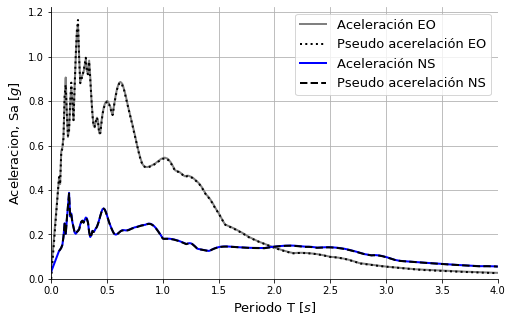

In [221]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(espectroEO['A_total_g'], lw=2, color='gray')
ax.plot(espectroEO['Sa'], lw=2, ls=':', color='k')
ax.plot(espectroNS['A_total_g'], lw=2, color='b')
ax.plot(espectroNS['Sa'], lw=2, ls='--', color='k')
# espectroEO[['A_total_g', 'Sa']].plot(ax=ax, color=['b', 'k'], lw=2)
plt.grid()#axis='y')
plt.xlim(0, periodos[-1])
plt.ylim(bottom=0)
plt.xlabel('Periodo T $[s]$', fontsize=13)
plt.ylabel('Aceleracion, Sa $[g]$', fontsize=13)
Aa = 0.15
Av = 0.20
Fa = 1.00#1.20
Fv = 1.00#1.60
To = 0.1*Av*Fv/(Aa*Fa)#0.18
Tc = 0.48*Av*Fv/(Aa*Fa)#0.85
TI = 2.4*Fv#3.84
FI = 1.00
T = espectroEO.index.values
Sa0 = 2.5 * Aa * Fa * FI * (0.4 + 0.6*T[T<To]/(To))
Sa1 = 2.5 * Aa * Fa * FI * (T[(To<=T)&(T<Tc)]/T[(To<=T)&(T<Tc)])
Sa2 = 1.2 * Av * Fv * FI / T[(Tc<=T)&(T<TI)]
Sa3 = 1.2 * Av * Fv * TI * FI / (T[TI<=T])**2
# plt.plot(T, np.r_[Sa0, Sa1, Sa2, Sa3], color='r', lw=2)
# legend = plt.legend(['Aceleración', 'Pseudo acerelación', 'Espectro NSR-10 (Suelo tipo b)'], fontsize=13)#, shadow=True)
legend = plt.legend(['Aceleración EO', 'Pseudo acerelación EO', 'Aceleración NS', 'Pseudo acerelación NS'], fontsize=13)#, shadow=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# legend.get_frame().set_facecolor('w')
# plt.title('EO')
plt.savefig('espectralEO.pdf', dpi=300, bbox_inches='tight')



In [218]:
espectroEO[espectroEO.index.values.round(2)==0.76]

,Desplazamiento,V_relativa,A_total_g,Sa
0.76,0.089221,0.686032,0.623743,0.62163


In [53]:
espectroEO.to_excel('Espectral_EO.xlsx')

In [54]:
dire = 'NS'
espectroNS = pd.DataFrame(columns=['Desplazamiento', 'V_relativa', 'A_total_g'])
espectroNS.loc[0] = np.array([0, 0, np.abs(split[dire].values[0] * -g)])
for t in periodos:
    espectroNS.loc[t] = beta_newmark(t, dire)
espectroNS['Sa'] = (2 * np.pi / espectroNS.index)**2 * espectroNS['Desplazamiento'] / g

# Gráfico: Espectro de respuesta NSR-10

Text(0.5, 1.0, 'NS')

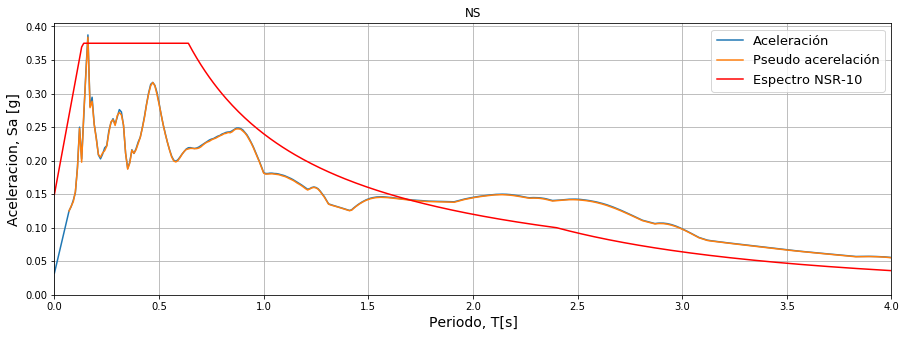

In [55]:
f, ax = plt.subplots(1, 1, figsize=(15, 5))
espectroNS[['A_total_g', 'Sa']].plot(ax=ax)
plt.grid()
plt.xlim(0, periodos[-1])
plt.ylim(bottom=0)
plt.xlabel('Periodo, T[s]', fontsize=14)
plt.ylabel('Aceleracion, Sa [g]', fontsize=14)
Aa = 0.15
Av = 0.20
Fa = 1.00#1.20
Fv = 1.00#1.60
To = 0.1*Av*Fv/(Aa*Fa)#0.18
Tc = 0.48*Av*Fv/(Aa*Fa)#0.85
TI = 2.4*Fv#3.84
FI = 1.00
T = espectroEO.index.values
Sa0 = 2.5 * Aa * Fa * FI * (0.4 + 0.6*T[T<To]/(To))
Sa1 = 2.5 * Aa * Fa * FI * (T[(To<=T)&(T<Tc)]/T[(To<=T)&(T<Tc)])
Sa2 = 1.2 * Av * Fv * FI / T[(Tc<=T)&(T<TI)]
Sa3 = 1.2 * Av * Fv * TI * FI / (T[TI<=T])**2
plt.plot(T, np.r_[Sa0, Sa1, Sa2, Sa3], color='r')
legend = plt.legend(['Aceleración', 'Pseudo acerelación', 'Espectro NSR-10'], fontsize=13)#, shadow=True)
plt.title('NS')

In [56]:
espectroNS.to_excel('Espectral_NS.xlsx')

# Respuesta total

In [58]:
respuesta_total = []
directions = {'x':'EO', 'y':'NS'}
for axis in directions.keys():
    dft = pd.DataFrame()
    for modo in range(self.pisos):
        dft = pd.concat((dft, beta_newmark_tabla(matriz_T.loc[modo, axis], directions[axis], a=alpha.loc[modo,axis])), axis=1)
    dft.columns = list(range(1, self.pisos+1))
    respuesta_total.append(dft)

In [59]:
ws

,x,y,z
0,69.111908,56.668989,89.906880
1,655.369656,556.306817,874.362358
2,1907.859534,1699.647061,2637.603414
3,3601.270814,3358.007287,5149.267802
4,4980.198137,4852.963307,7357.930075


In [60]:
respuesta_total[1]

,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
1,-0.000314,0.000110,0.000067,-4.258306e-05,2.168953e-05
2,-0.000453,0.000135,0.000051,-5.380794e-06,-9.414600e-06
3,-0.000412,0.000071,-0.000031,5.622609e-05,-3.028787e-05
4,-0.000029,-0.000120,-0.000155,8.285237e-05,-1.521698e-05
...,...,...,...,...,...
2195,-0.063643,-0.000141,0.000017,3.653073e-07,3.878014e-07
2196,-0.063808,-0.000156,0.000006,-2.613357e-06,3.301623e-07
2197,-0.062546,-0.000133,-0.000006,-3.299439e-06,3.618187e-07
2198,-0.059907,-0.000078,-0.000010,-1.270223e-06,5.130373e-07


In [61]:
alginx = pd.DataFrame(phi).loc[:, list(range(dir_dic['x'], 15, 3))]
alginx[alginx.round(5)==0] = np.nan
alginx = alginx.dropna()
alginx

,0,3,6,9,12
0,0.026661,0.028483,0.030852,-0.031101,0.022958
3,0.025048,0.014858,-0.002112,0.018074,-0.020199
6,0.020839,-0.009969,-0.024282,0.000544,0.021535
9,0.014242,-0.025296,0.005649,-0.019112,-0.018639
12,0.006202,-0.017400,0.024096,0.022542,0.012542


In [62]:
alginy = pd.DataFrame(phi).loc[:, list(range(dir_dic['y'], 15, 3))]
alginy[alginy.round(5)==0] = np.nan
alginy = alginy.dropna()
alginy

,1,4,7,10,13
1,0.026991,0.029348,-0.032007,-0.030869,-0.020027
4,0.025191,0.014294,0.003774,0.019495,0.018818
7,0.020789,-0.010835,0.023597,-0.002453,-0.021792
10,0.013970,-0.025414,-0.007387,-0.017197,0.019899
13,0.005826,-0.016590,-0.023492,0.022899,-0.014209


### Gráfico Respuesta total

(5, 2)


<Figure size 2376x360 with 0 Axes>

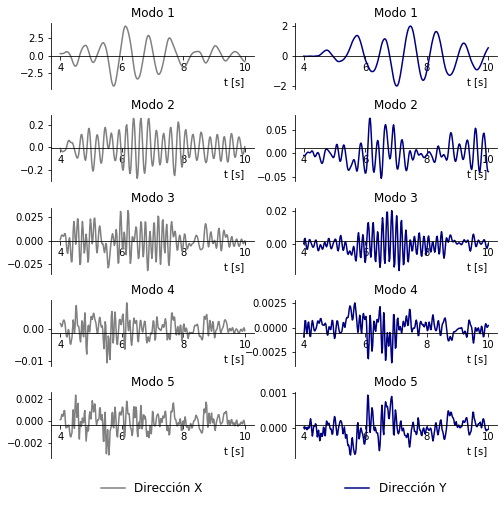

In [287]:
respuesta_total[0].index = split.index
respuesta_total[1].index = split.index
respuesta_total[0].columns = [0, 1, 2, 3, 4]
respuesta_total[1].columns = [0, 1, 2, 3, 4]
plt.figure(figsize=(33, 5))
f, ax = plt.subplots(5, 2, figsize=(8, 8))#, sharey=True)
print(ax.shape)
estox = [0, 1, 2, 3, 4]
posi = [0, 0, 0, 0, 0]
for i in range(5):
#     print(estox[i], posi[i])
    where = np.array(((4<=respuesta_total[0].index)&(respuesta_total[0].index<=10)))
    maximo_x = respuesta_total[0][i].loc[respuesta_total[0][where][i].abs().idxmax()]
    idx_maximo = respuesta_total[0][where][i].abs().idxmax()
    maximo_y = respuesta_total[1][i].loc[respuesta_total[1][where][i].abs().idxmax()]
    idy_maximo = respuesta_total[1][where][i].abs().idxmax()
    
    ax[estox[i]][posi[i]].set_title('Modo %s'%(i+1))
    ax[estox[i]][posi[i]].set_xlabel('t [s]', position=(0.9, 1))
    ax[estox[i]][posi[i]].plot(respuesta_total[0][where][i], color='gray')
#     ax[estox[i]][posi[i]].scatter(idx_maximo, maximo_x, color='gray')
#     ax[estox[i]][posi[i]].plot(respuesta_total[1][where][i], color='navy')
#     ax[estox[i]][posi[i]].scatter(idy_maximo, maximo_y, color='navy')
    ax[estox[i]][posi[i]].spines['bottom'].set_position('center')
    ax[estox[i]][posi[i]].spines['top'].set_visible(False)
    ax[estox[i]][posi[i]].spines['right'].set_visible(False)
    if estox[i]==2 and posi[i]==0:
        ax[estox[i]][posi[i]].legend(['Dirección X', '$Z_y$'], bbox_to_anchor=(0.8, -3.), fontsize=12, frameon=False)
estox = [0, 1, 2, 3, 4]
posi = [1, 1, 1, 1, 1]
for i in range(5):
#     print(estox[i], posi[i])
    where = np.array(((4<=respuesta_total[0].index)&(respuesta_total[0].index<=10)))
    maximo_x = respuesta_total[0][i].loc[respuesta_total[0][where][i].abs().idxmax()]
    idx_maximo = respuesta_total[0][where][i].abs().idxmax()
    maximo_y = respuesta_total[1][i].loc[respuesta_total[1][where][i].abs().idxmax()]
    idy_maximo = respuesta_total[1][where][i].abs().idxmax()
    
    ax[estox[i]][posi[i]].set_title('Modo %s'%(i+1))
    ax[estox[i]][posi[i]].set_xlabel('t [s]', position=(0.9, 1))
#     ax[estox[i]][posi[i]].plot(respuesta_total[0][where][i], color='gray')
#     ax[estox[i]][posi[i]].scatter(idx_maximo, maximo_x, color='gray')
    ax[estox[i]][posi[i]].plot(respuesta_total[1][where][i], color='navy')
    ax[estox[i]][posi[i]].spines['bottom'].set_position('center')
    ax[estox[i]][posi[i]].spines['top'].set_visible(False)
    ax[estox[i]][posi[i]].spines['right'].set_visible(False)
    
#     ax[estox[i]][posi[i]].scatter(idy_maximo, maximo_y, color='navy')
    if estox[i]==2 and posi[i]==1:
        ax[estox[i]][posi[i]].legend(['Dirección Y', '$Z_y$'], bbox_to_anchor=(0.8, -3.), fontsize=12, frameon=False)
    
    
    #######
    
    
#     ax[estox[i]][posi[i]].plot([4, idx_maximo], [maximo_x, maximo_x], color='k', ls=':')
#     ax[estox[i]][posi[i]].plot([idx_maximo, idx_maximo], [-0.15, maximo_x], color='k', ls=':')
#     ax[estox[i]][posi[i]].axhline(maximo_x, color='k', ls=':')
#     ax[estox[i]][posi[i]].axvline(idx_maximo, color='k', ls=':')
    
    
    #######
    
    
#     ax[estox[i]][posi[i]].plot([4, idy_maximo], [maximo_y, maximo_y], color='k', ls=':')
#     ax[estox[i]][posi[i]].plot([idy_maximo, idy_maximo], [-0.15, maximo_y], color='k', ls=':')
#     ax[estox[i]][posi[i]].axhline(maximo_y, color='k', ls=':')
#     ax[estox[i]][posi[i]].axvline(idy_maximo, color='k', ls=':')
    
#     ax[estox[i]][posi[i]].set_xlim([4, 10])
#     ax[estox[i]][posi[i]].set_ylim(bottom=-0.14)   
    #######
    
    
#     ax[estox[i]][posi[i]].plot([4, idx_maximo], [maximo_x, maximo_x], color='k', ls=':')
#     ax[estox[i]][posi[i]].plot([idx_maximo, idx_maximo], [-0.15, maximo_x], color='k', ls=':')
#     ax[estox[i]][posi[i]].axhline(maximo_x, color='k', ls=':')
#     ax[estox[i]][posi[i]].axvline(idx_maximo, color='k', ls=':')
    
    
    #######
    
    
#     ax[estox[i]][posi[i]].plot([4, idy_maximo], [maximo_y, maximo_y], color='k', ls=':')
#     ax[estox[i]][posi[i]].plot([idy_maximo, idy_maximo], [-0.15, maximo_y], color='k', ls=':')
#     ax[estox[i]][posi[i]].axhline(maximo_y, color='k', ls=':')
#     ax[estox[i]][posi[i]].axvline(idy_maximo, color='k', ls=':')
    
#     ax[estox[i]][posi[i]].set_xlim([4, 10])
#     ax[estox[i]][posi[i]].set_ylim(bottom=-0.14)

# f.delaxes(ax[2][1])
f.subplots_adjust(hspace=0.4)
# f.suptitle('Deformaciones', y=0.94)
# ax[1].plot(respuesta_total[0][respuesta_total[0].index<=10][1])
# ax[1].set_title('Piso 4')
# ax[2].plot(respuesta_total[0][respuesta_total[0].index<=10][2])
# ax[2].set_title('Piso 3')
# ax[3].plot(respuesta_total[0][respuesta_total[0].index<=10][3])
# ax[3].set_title('Piso 2')
# ax[4].plot(respuesta_total[0][respuesta_total[0].index<=10][4])
# ax[4].set_title('Piso 1')
plt.savefig('respuesta_total.pdf', dpi=300, bbox_inches='tight')

### Gráfico: respuesta temporal total

(3, 2)


<Figure size 1080x360 with 0 Axes>

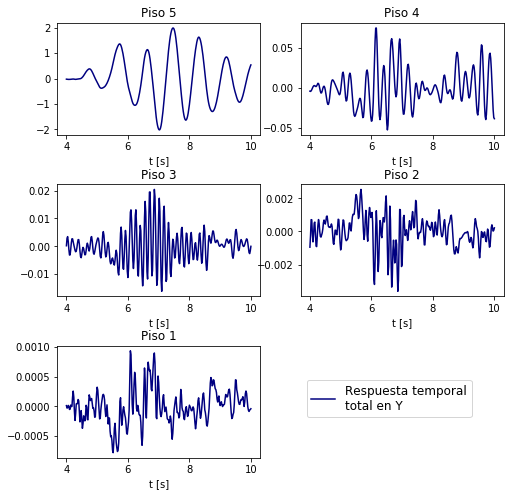

In [248]:
respuesta_total[0].index = split.index
respuesta_total[1].index = split.index
respuesta_total[0].columns = [0, 1, 2, 3, 4]
respuesta_total[1].columns = [0, 1, 2, 3, 4]
plt.figure(figsize=(15, 5))
f, ax = plt.subplots(3, 2, figsize=(8, 8))#, sharey=True)
print(ax.shape)
estox = [0, 0, 1, 1, 2, 2]
posi = [0, 1, 0, 1, 0]
for i in range(5):
#     print(estox[i], posi[i])
    where = np.array(((4<=respuesta_total[0].index)&(respuesta_total[0].index<=10)))
    maximo_x = respuesta_total[0][i].loc[respuesta_total[0][where][i].abs().idxmax()]
    idx_maximo = respuesta_total[0][where][i].abs().idxmax()
    maximo_y = respuesta_total[1][i].loc[respuesta_total[1][where][i].abs().idxmax()]
    idy_maximo = respuesta_total[1][where][i].abs().idxmax()
    
    ax[estox[i]][posi[i]].set_title('Modo %s'%(i+1))
    ax[estox[i]][posi[i]].set_xlabel('t [s]')
#     ax[estox[i]][posi[i]].plot(respuesta_total[0][where][i], color='gray')
#     ax[estox[i]][posi[i]].scatter(idx_maximo, maximo_x, color='gray')
    ax[estox[i]][posi[i]].plot(respuesta_total[1][where][i], color='navy')
#     ax[estox[i]][posi[i]].scatter(idy_maximo, maximo_y, color='navy')
    if estox[i]==2 and posi[i]==0:
        ax[estox[i]][posi[i]].legend(['Respuesta temporal\ntotal en Y', '$Z_y$'], ncol=2, bbox_to_anchor=(1.2, 0.75), fontsize=12)
    
    
    #######
    
    
#     ax[estox[i]][posi[i]].plot([4, idx_maximo], [maximo_x, maximo_x], color='k', ls=':')
#     ax[estox[i]][posi[i]].plot([idx_maximo, idx_maximo], [-0.15, maximo_x], color='k', ls=':')
#     ax[estox[i]][posi[i]].axhline(maximo_x, color='k', ls=':')
#     ax[estox[i]][posi[i]].axvline(idx_maximo, color='k', ls=':')
    
    
    #######
    
    
#     ax[estox[i]][posi[i]].plot([4, idy_maximo], [maximo_y, maximo_y], color='k', ls=':')
#     ax[estox[i]][posi[i]].plot([idy_maximo, idy_maximo], [-0.15, maximo_y], color='k', ls=':')
#     ax[estox[i]][posi[i]].axhline(maximo_y, color='k', ls=':')
#     ax[estox[i]][posi[i]].axvline(idy_maximo, color='k', ls=':')
    
#     ax[estox[i]][posi[i]].set_xlim([4, 10])
#     ax[estox[i]][posi[i]].set_ylim(bottom=-0.14)

f.delaxes(ax[2][1])
f.subplots_adjust(hspace=0.44)
# f.suptitle('Deformaciones', y=0.94)
# ax[1].plot(respuesta_total[0][respuesta_total[0].index<=10][1])
# ax[1].set_title('Piso 4')
# ax[2].plot(respuesta_total[0][respuesta_total[0].index<=10][2])
# ax[2].set_title('Piso 3')
# ax[3].plot(respuesta_total[0][respuesta_total[0].index<=10][3])
# ax[3].set_title('Piso 2')
# ax[4].plot(respuesta_total[0][respuesta_total[0].index<=10][4])
# ax[4].set_title('Piso 1')
plt.savefig('respuesta_total_y.pdf', dpi=300, bbox_inches='tight')

In [233]:
respuesta_total[0][respuesta_total[0].index.values.round(2)<=35.98].sum().sum()

0.10107453112325634

In [63]:
alginx.shape, alginy.shape, respuesta_total[0].shape

((5, 5), (5, 5), (2200, 5))

In [64]:
Ux = pd.DataFrame(respuesta_total[0].values.dot(alginx.T.values), index=split.index)
Uy = pd.DataFrame(respuesta_total[1].values.dot(alginy.T.values), index=split.index)

### Gráfico: máximas deformaciones

(3, 2)


<Figure size 1080x360 with 0 Axes>

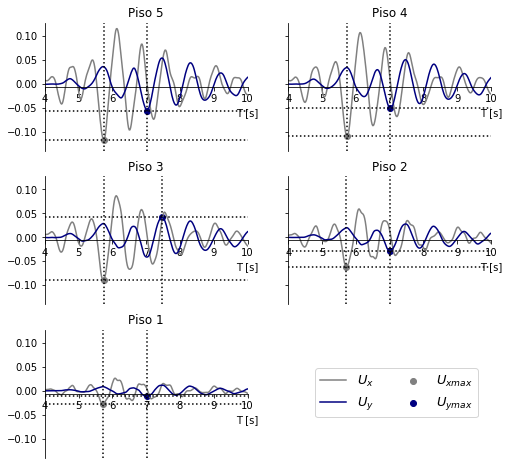

In [290]:
plt.figure(figsize=(15, 5))
f, ax = plt.subplots(3, 2, figsize=(8, 8), sharey=True)
print(ax.shape)
estox = [0, 0, 1, 1, 2, 2]
posi = [0, 1, 0, 1, 0]
for i in range(5):
#     print(estox[i], posi[i])
    where = np.array(((4<=Ux.index)&(Ux.index<=10)))
    maximo_x = Ux[i].loc[Ux[where][i].abs().idxmax()]
    idx_maximo = Ux[where][i].abs().idxmax()
    maximo_y = Uy[i].loc[Uy[where][i].abs().idxmax()]
    idy_maximo = Uy[where][i].abs().idxmax()
    
    ax[estox[i]][posi[i]].set_title('Piso %s'%(5-i))
    ax[estox[i]][posi[i]].set_xlabel('T [s]', position=(1, 1))
    ax[estox[i]][posi[i]].plot(Ux[where][i], color='gray')
    ax[estox[i]][posi[i]].scatter(idx_maximo, maximo_x, color='gray')
    ax[estox[i]][posi[i]].plot(Uy[where][i], color='navy')
    ax[estox[i]][posi[i]].scatter(idy_maximo, maximo_y, color='navy')
    if estox[i]==2 and posi[i]==0:
        ax[estox[i]][posi[i]].legend(['$U_x$', '$U_y$', '$U_{xmax}$', '$U_{ymax}$'], ncol=2, bbox_to_anchor=(1.3, 0.75), fontsize=13)
    
    
    #######
    
    
#     ax[estox[i]][posi[i]].plot([4, idx_maximo], [maximo_x, maximo_x], color='k', ls=':')
#     ax[estox[i]][posi[i]].plot([idx_maximo, idx_maximo], [-0.15, maximo_x], color='k', ls=':')
    ax[estox[i]][posi[i]].axhline(maximo_x, color='k', ls=':')
    ax[estox[i]][posi[i]].axvline(idx_maximo, color='k', ls=':')
    ax[estox[i]][posi[i]].spines['bottom'].set_position('center')
    ax[estox[i]][posi[i]].spines['top'].set_visible(False)
    ax[estox[i]][posi[i]].spines['right'].set_visible(False)
    
    #######
    
    
#     ax[estox[i]][posi[i]].plot([4, idy_maximo], [maximo_y, maximo_y], color='k', ls=':')
#     ax[estox[i]][posi[i]].plot([idy_maximo, idy_maximo], [-0.15, maximo_y], color='k', ls=':')
    ax[estox[i]][posi[i]].axhline(maximo_y, color='k', ls=':')
    ax[estox[i]][posi[i]].axvline(idy_maximo, color='k', ls=':')
    
    ax[estox[i]][posi[i]].set_xlim([4, 10])
    ax[estox[i]][posi[i]].set_ylim(bottom=-0.14)

f.delaxes(ax[2][1])
# f.subplots_adjust(hspace=0.44)
# f.suptitle('Deformaciones', y=0.94)
# ax[1].plot(Ux[Ux.index<=10][1])
# ax[1].set_title('Piso 4')
# ax[2].plot(Ux[Ux.index<=10][2])
# ax[2].set_title('Piso 3')
# ax[3].plot(Ux[Ux.index<=10][3])
# ax[3].set_title('Piso 2')
# ax[4].plot(Ux[Ux.index<=10][4])
# ax[4].set_title('Piso 1')
plt.savefig('Deformaciones.pdf', dpi=300, bbox_inches='tight')

In [66]:
axis = 0
Kx = pd.DataFrame(self.rigidez).astype(float).loc[(pd.DataFrame(self.rigidez).astype(float).round(4)!=0).iloc[:, axis], (pd.DataFrame(self.rigidez).astype(float).round(4)!=0).iloc[axis]]
axis = 1
Ky = pd.DataFrame(self.rigidez).astype(float).loc[(pd.DataFrame(self.rigidez).astype(float).round(4)!=0).iloc[:, axis], (pd.DataFrame(self.rigidez).astype(float).round(4)!=0).iloc[axis]]

In [67]:
Kx.shape, Ky.shape, Ux.shape, Uy.shape

((5, 5), (5, 5), (2200, 5), (2200, 5))

In [68]:
Fx = pd.DataFrame(Ux.values.dot(Kx.values), index=split.index)
Fy = pd.DataFrame(Uy.values.dot(Ky.values), index=split.index)

(3, 2)


Text(0.5, 0.95, 'Deformaciones')

<Figure size 1080x360 with 0 Axes>

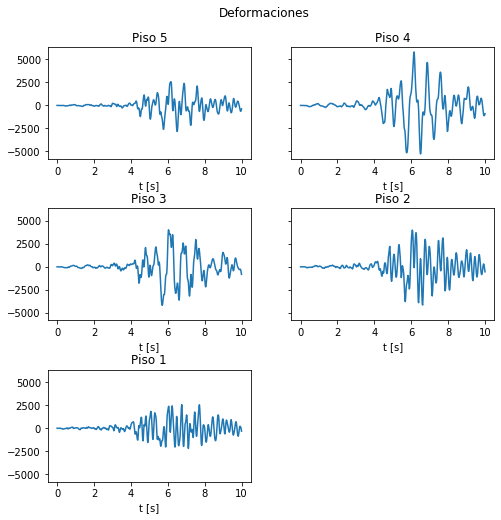

In [69]:
plt.figure(figsize=(15, 5))
f, ax = plt.subplots(3, 2, figsize=(8, 8), sharey=True)
print(ax.shape)
estox = [0, 0, 1, 1, 2, 2]
posi = [0, 1, 0, 1, 0]
for i in range(5):
#     print(estox[i], posi[i])
    ax[estox[i]][posi[i]].plot(Fx[Fx.index<=10][i])
    ax[estox[i]][posi[i]].set_title('Piso %s'%(5-i))
    ax[estox[i]][posi[i]].set_xlabel('t [s]')
f.delaxes(ax[2][1])
f.subplots_adjust(hspace=0.44)
f.suptitle('Deformaciones', y=0.95)
# ax[1].plot(Fx[Fx.index<=10][1])
# ax[1].set_title('Piso 4')
# ax[2].plot(Fx[Fx.index<=10][2])
# ax[2].set_title('Piso 3')
# ax[3].plot(Fx[Fx.index<=10][3])
# ax[3].set_title('Piso 2')
# ax[4].plot(Fx[Fx.index<=10][4])
# ax[4].set_title('Piso 1')

In [70]:
cortante_basal_x = Fx.sum(axis=1)
cortante_basal_y = Fy.sum(axis=1)

In [71]:
brazos = np.cumsum(np.array([3.2] * self.pisos))

In [123]:
momento_basal_x = pd.DataFrame(brazos[::-1].dot(Fx.T), Fx.index)
momento_basal_y = pd.DataFrame(brazos[::-1].dot(Fy.T), Fy.index)

In [124]:
cortante_basal_x.sum(), cortante_basal_y.sum(), momento_basal_y.sum()#[cortante_basal_x<=35.98].sum()

(437.63334629149995, -609.3733196822668, 0   -6267.993447
 dtype: float64)

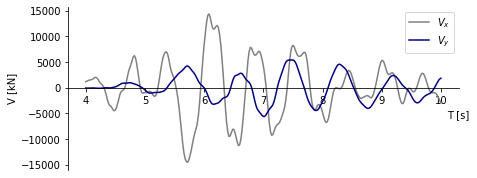

In [202]:
plt.figure(figsize=(7, 3))
plt.plot(cortante_basal_x[4:10], color='gray', label='$V_x$')
plt.plot(cortante_basal_y[4:10], color='navy', label='$V_y$')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_position('center')
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.axhline(0, color='k', lw=0.7)
xaxis = plt.gca().xaxis.set_tick_params(bottom='off')
plt.xticks([4, 5, 6, 7, 8, 9, 10], position=(0.5, 0.5));
plt.gca().xaxis.set_tick_params(bottom='off')
plt.ylabel('V [kN]')
plt.xlabel('T [s]', position=(1, 1))
plt.legend()
plt.savefig('Cortante_Basal.pdf', dpi=300, bbox_inches='tight')

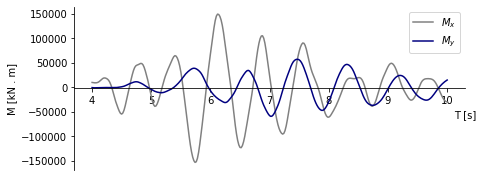

In [200]:
plt.figure(figsize=(7, 3))
plt.plot(momento_basal_x[4:10], color='gray', label='$M_x$')
plt.plot(momento_basal_y[4:10], color='navy', label='$M_y$')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_position('center')
# plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.axhline(0, color='k', lw=0.7)
xaxis = plt.gca().xaxis.set_tick_params(bottom='off')
plt.xticks([4, 5, 6, 7, 8, 9, 10], position=(0.5, 0.5));
plt.gca().xaxis.set_tick_params(bottom='off')
# xaxis.
plt.ylabel('M [kN . m]')
plt.xlabel('T [s]', position=(1, 1))
plt.legend()
plt.savefig('Momento_Basal.pdf', dpi=300, bbox_inches='tight')

In [173]:
xaxis.set_t

In [73]:
maximos_x = pd.DataFrame([np.max(np.abs(Ux[i])) for i in Ux.columns], index=[np.abs(Ux[i]).idxmax() for i in Ux.columns])
maximos_y = pd.DataFrame([np.max(np.abs(Uy[i])) for i in Ux.columns], index=[np.abs(Uy[i]).idxmax() for i in Uy.columns])

In [74]:
maximos_x

,0
5.74,0.117341
5.74,0.109652
5.74,0.089994
5.72,0.061265
5.72,0.026762


In [75]:
derivas_x = pd.DataFrame((Ux.iloc[:,1:].values - Ux.iloc[:,:-1].values), columns=list(range(1, self.pisos)))
derivas_x[0] = Ux[0]
derivas_x = derivas_x.sort_index()
np.abs(derivas_x).max(axis=0)/3.2*100

1    0.282541
2    0.680321
3    0.959969
4    1.078242
0    1.582793
dtype: float64

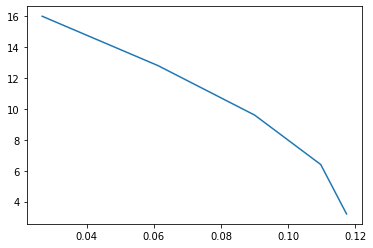

In [76]:
plt.plot(maximos_x, brazos)

In [77]:
print(cortante_basal_x.loc[np.median(maximos_x.index)], momento_basal_x.loc[np.median(maximos_x.index)])
print(np.abs(cortante_basal_x).max(), np.abs(momento_basal_x).max())

-14052.227767553828 -116695.08489014434
14492.712264229118 148220.766224817


# Gráficos derivas

### En X e Y

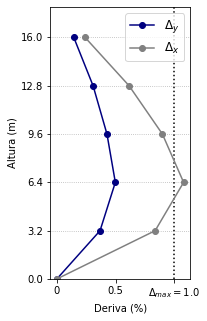

In [78]:
plt.figure(figsize=(2.5, 5))
plt.axvline(1, color='k', ls=':')
plt.ylim([0, 18])
plt.plot(np.r_[[0], ((maximos_y.values.ravel() - np.r_[maximos_y.values[1:].ravel(), [0]])/3.2 * 100)[::-1]], [0, 3.2, 6.4, 9.6, 12.8, 16], marker='o', color='navy', label='$\Delta_y$')
plt.plot(np.r_[[0], ((maximos_x.values.ravel() - np.r_[maximos_x.values[1:].ravel(), [0]])/3.2 * 100)[::-1]], [0, 3.2, 6.4, 9.6, 12.8, 16], marker='o', color='gray', label='$\Delta_x$')
plt.ylabel('Altura (m)')
plt.xlabel('Deriva (%)')
plt.legend(fontsize=12)
plt.yticks([0, 3.2, 6.4, 9.6, 12.8, 16])
plt.xticks([0, 0.5, 1.0], ['0', '0.5', '$\Delta_{max} = 1.0$'])
plt.grid(axis='y', ls=':')
plt.savefig('Derivas.pdf', dpi=300, bbox_inches='tight')

### En X

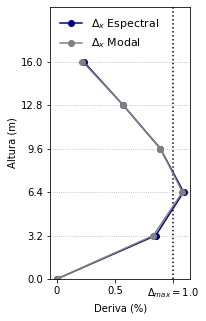

In [79]:
plt.figure(figsize=(2.5, 5))
plt.axvline(1, color='k', ls=':')
plt.ylim([0, 20])
plt.plot([0, 0.85, 1.09, 0.89, 0.57, 0.23], [0, 3.2, 6.4, 9.6, 12.8, 16], marker='o', color='navy', label='$\Delta_x$ Espectral')
plt.plot([0, 0.83, 1.08, 0.89, 0.57, 0.22], [0, 3.2, 6.4, 9.6, 12.8, 16], marker='o', color='gray', label='$\Delta_x$ Modal')
plt.ylabel('Altura (m)')
plt.xlabel('Deriva (%)')
plt.legend(fontsize=11, frameon=False)
plt.yticks([0, 3.2, 6.4, 9.6, 12.8, 16])
plt.xticks([0, 0.5, 1.0], ['0', '0.5', '$\Delta_{max}=1.0$'])
plt.grid(axis='y', ls=':')
plt.savefig('Derivas_X.pdf', dpi=300, bbox_inches='tight')

### En Y

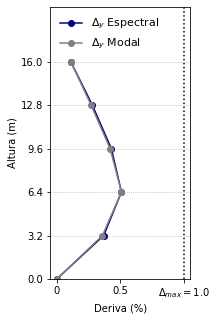

In [80]:
plt.figure(figsize=(2.5, 5))
plt.axvline(1, color='k', ls=':')
plt.ylim([0, 20])
plt.plot([0, 0.37, 0.51, 0.43, 0.28, 0.11], [0, 3.2, 6.4, 9.6, 12.8, 16], marker='o', color='navy', label='$\Delta_y$ Espectral')
plt.plot([0, 0.36, 0.51, 0.42, 0.27, 0.11], [0, 3.2, 6.4, 9.6, 12.8, 16], marker='o', color='gray', label='$\Delta_y$ Modal')
plt.ylabel('Altura (m)')
plt.xlabel('Deriva (%)')
plt.legend(fontsize=11, frameon=False)
plt.yticks([0, 3.2, 6.4, 9.6, 12.8, 16])
plt.xticks([0, 0.5, 1.0], ['0', '0.5', '$\Delta_{max}=1.0$'])
plt.grid(axis='y', ls=':')
plt.savefig('Derivas_Y.pdf', dpi=300, bbox_inches='tight')

In [82]:
print(cortante_basal_y.loc[np.median(maximos_y.index)], momento_basal_y.loc[np.median(maximos_y.index)])
print(np.abs(cortante_basal_y).max(), np.abs(momento_basal_y).max())

-5598.461080697105 -48145.681236923345
5598.726893112069 49571.32566426732


In [83]:
derivas_y = pd.DataFrame((Uy.iloc[:,1:].values - Uy.iloc[:,:-1].values), columns=list(range(1, self.pisos)))
derivas_y[0] = Uy[0]
derivas_y = derivas_y.sort_index(axis=1)
np.abs(derivas_y).max(axis=0)/3.2*100

0    1.700150
1    0.144380
2    0.309379
3    0.430268
4    0.504388
dtype: float64

In [86]:
alginx/3.2*100

,0,3,6,9,12
0,0.833167,0.890088,0.964117,-0.971903,0.717431
3,0.782748,0.464317,-0.066009,0.564812,-0.631224
6,0.651226,-0.311527,-0.758798,0.017013,0.672972
9,0.445058,-0.790495,0.176535,-0.597258,-0.582460
12,0.193816,-0.543760,0.752991,0.704445,0.391946


In [87]:
alginy/3.2*100

,1,4,7,10,13
1,0.843474,0.917129,-1.000215,-0.964658,-0.625843
4,0.787230,0.446673,0.117933,0.609206,0.588056
7,0.649655,-0.338586,0.737415,-0.076649,-0.680992
10,0.436563,-0.794181,-0.230853,-0.537405,0.621845
13,0.182070,-0.518427,-0.734128,0.715585,-0.444045


In [88]:
respuesta_total[0].T.to_excel('X_EO_RespuestaTotal.xlsx')

In [89]:
respuesta_total[1].T.to_excel('Y_NS_RespuestaTotal.xlsx')

In [90]:
pd.DataFrame(phi).round(4).sum().sum()

0.1613

In [91]:
respuesta_total[0].sum(axis=0)

1    0.121571
2   -0.001991
3    0.000311
4    0.000095
5    0.000032
dtype: float64

In [92]:
Uy.max(axis=0)

0    0.053712
1    0.050211
2    0.041345
3    0.027657
4    0.011517
dtype: float64

In [212]:
"""ESTUDIO DE LOS DIAFRAGMAS HORIZONTALES FLEXIBLES PARA ENTREPISO Y CUBIERTA""".capitalize()

'Estudio de los diafragmas horizontales flexibles para entrepiso y cubierta'